<a href="https://colab.research.google.com/github/jbeen2/Today-I-Learned/blob/main/2020-2-NLP/4_POS_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POS Tagging 
* POS : Part Of Speech
* the process of classifying words into their parts of speech
* ex) Noun, Verb, Adjective, Adverb, Pronoun, …

## 0. POS Tagging 

### 1) Picking a Corpus to train the POS tagger
* using [Penn Treebank tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) 
* Most of the already trained taggers for English are trained on this tag set

In [1]:
# download corpus
import nltk
nltk.download('treebank') 

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [2]:
from nltk.corpus import treebank
sentences = treebank.tagged_sents()

In [4]:
print(sentences[0])
print("Tagged sentences: ", len(sentences))
print("Tagged words:", len(treebank.tagged_words()))

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


In [3]:
tags = set([
    tag for sentence in treebank.tagged_sents() 
    for _, tag in sentence
])

print('nb_tags: %s\ntags: %s' % (len(tags), tags))

nb_tags: 46
tags: {'POS', 'PRP$', 'NN', 'VB', 'VBG', 'NNPS', 'NNP', 'PDT', 'UH', 'VBZ', 'VBP', 'RP', 'VBN', '-RRB-', ',', 'RB', 'DT', 'RBR', 'SYM', 'IN', '#', '``', '.', 'JJS', 'JJR', 'VBD', 'CD', 'WDT', 'TO', 'PRP', '-LRB-', 'WP$', 'LS', 'EX', 'RBS', 'JJ', 'NNS', 'FW', ':', 'MD', '-NONE-', 'WP', 'CC', "''", 'WRB', '$'}


### 2) Feature Engineering 
* To catch **Characteristic of the word** 
* 2-letter suffix is a great indicator of **past-tense verbs**, ending in **“-ed”**.
* 3-letter suffix helps recognize the **present** participle ending in **“-ing”**.

In [3]:
def add_basic_features(sentence_terms, index):

    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """

    term = sentence_terms[index]

    return {
        'nb_terms': len(sentence_terms),                # word length 
        'term': term,                                   # the word itself 
        'is_first': index == 0,                         # First or not (T/F)
        'is_last': index == len(sentence_terms) - 1,    # Last or not 
        'is_capitalized': term[0].upper() == term[0],   # Capitalized or not 
        'is_all_caps': term.upper() == term,            # All of the letters are Capitalized or not 
        'is_all_lower': term.lower() == term,           # All of the letters are Lowercased or not 
        'prefix-1': term[0],                            # First Letter 
        'prefix-2': term[:2],                           # ~Second Letter 
        'prefix-3': term[:3],                           # ~Third Letter 
        'suffix-1': term[-1],                           # Last Letter 
        'suffix-2': term[-2:],                          # The Second Letter form the end 
        'suffix-3': term[-3:],                          # The Third Letter from the end 
        'prev_word': '' if index == 0 else sentence_terms[index - 1],       # Previous word 
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1],      # Next word 
        'has_hyphen': '-' in sentence_terms[index],
        'is_numeric': sentence_terms[index].isdigit(),
        'capitals_inside': sentence_terms[index][1:].lower() != sentence_terms[index][1:]
    }

In [4]:
# example : "burning"
add_basic_features(["I", "am", "burning", "in", "NLP"], 2)

{'capitals_inside': False,
 'has_hyphen': False,
 'is_all_caps': False,
 'is_all_lower': True,
 'is_capitalized': False,
 'is_first': False,
 'is_last': False,
 'is_numeric': False,
 'nb_terms': 5,
 'next_word': 'in',
 'prefix-1': 'b',
 'prefix-2': 'bu',
 'prefix-3': 'bur',
 'prev_word': 'am',
 'suffix-1': 'g',
 'suffix-2': 'ng',
 'suffix-3': 'ing',
 'term': 'burning'}

In [5]:
# strip the tags from our tagged corpus
def untag(tagged_sentence):

    """ 
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """

    return [w for w, _ in tagged_sentence]

### 3) Split the Dataset for training and testing
* train : test = 80 : 20 
* train : val  = 75 : 25

In [6]:
# train, test split 
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]

# train, validation split 
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

In [7]:
print("train : ", len(training_sentences))
print("validation : ", len(validation_sentences))
print("test : ", len(testing_sentences))

train :  2349
validation :  782
test :  783


In [8]:
def transform_to_dataset(tagged_sentences):

    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """

    X, y = [], []

    for pos_tags in tagged_sentences:
            for index, (term, class_) in enumerate(pos_tags):
                # Add basic NLP features for each sentence term
                X.append(add_basic_features(untag(pos_tags), index))
                y.append(class_)
                
    return X, y

In [9]:
X_train, y_train = transform_to_dataset(training_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)

In [13]:
X_train[0]

{'capitals_inside': False,
 'has_hyphen': False,
 'is_all_caps': False,
 'is_all_lower': False,
 'is_capitalized': True,
 'is_first': True,
 'is_last': False,
 'is_numeric': False,
 'nb_terms': 28,
 'next_word': 'Ward',
 'prefix-1': 'M',
 'prefix-2': 'Mr',
 'prefix-3': 'Mrs',
 'prev_word': '',
 'suffix-1': '.',
 'suffix-2': 's.',
 'suffix-3': 'rs.',
 'term': 'Mrs.'}

In [14]:
y_train[0]

'NNP'

In [10]:
print("train : ", len(X_train))
print("validation : ", len(X_val))
print("test : ", len(X_test))

train :  61107
validation :  19530
test :  20039


## 1. Machine Learning based POS Tagging 
* https://nlpforhackers.io/training-pos-tagger/
* Decision Tree 


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

In [19]:
clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='entropy'))
])

In [20]:
%%time
clf.fit(X_train[:30000], y_train[:30000])

CPU times: user 53.4 s, sys: 2.52 s, total: 56 s
Wall time: 56 s


Pipeline(memory=None,
         steps=[('vectorizer',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=False)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [21]:
# Accuracy 
clf.score(X_test, y_test)

0.9181595888018365

In [12]:
# Predict with our Classifier 
def postag(sentence):
    tags = clf.predict([add_basic_features(sentence, index) for index in range(len(sentence))])
    tagged_sentence = list(map(list, zip(sentence, tags)))
    return tagged_sentence

In [13]:
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
text = "It's 2AM, so I am about to going to my bed."

In [39]:
# text 에 대해 ML model로 POS tagging 한 결과 
postag(word_tokenize(text))

[['I', 'PRP'],
 ['am', 'NN'],
 ['about', 'IN'],
 ['to', 'TO'],
 ['going', 'VBG'],
 ['to', 'TO'],
 ['my', 'VB'],
 ['bed', 'VBN'],
 ['.', '.']]

## 2. DeepLearning based POS Tagging
* https://becominghuman.ai/part-of-speech-tagging-tutorial-with-the-keras-deep-learning-library-d7f93fa05537 

### 1) Data Preprocessing 

In [14]:
# RAM이 계속 터져서 어쩔 수 없이 데이터의 일부만 사용하였습니다. 
X_train_, y_train_ = X_train[:10000], y_train[:10000] 
X_val_, y_val_ = X_val[:2000], y_val[:2000] 
X_test_, y_test_ = X_test[:2000], y_test[:2000] 

In [15]:
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train_ + X_test_ + X_val_)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [16]:
# Convert dict features to vectors
X_train_ = dict_vectorizer.transform(X_train_)
X_test_ = dict_vectorizer.transform(X_test_)
X_val_ = dict_vectorizer.transform(X_val_)

In [17]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ + y_test_ + y_val_)

LabelEncoder()

In [18]:
# Encode class values as integers
y_train_ = label_encoder.transform(y_train_)
y_test_ = label_encoder.transform(y_test_)
y_val_ = label_encoder.transform(y_val_)

In [19]:
print("train : ", X_train_.shape, y_train_.shape)
print("validation : ", X_val_.shape, y_val_.shape)
print("test : ", X_test_.shape, y_test_.shape)

train :  (10000, 14577) (10000,)
validation :  (2000, 14577) (2000,)
test :  (2000, 14577) (2000,)


In [20]:
# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils

y_train_ = np_utils.to_categorical(y_train_)
y_test_ = np_utils.to_categorical(y_test_)
y_val_ = np_utils.to_categorical(y_val_)

### 2) Modeling 

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
from keras.wrappers.scikit_learn import KerasClassifier

model_params = {
    'build_fn': build_model,
    'input_dim': X_train_.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train_.shape[1],
    'epochs': 50,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val_, y_val_),
    'shuffle': True
}

clf = KerasClassifier(**model_params)

In [34]:
# Early Stopping 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10) 

In [35]:
hist = clf.fit(X_train_, y_train_, callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 1s 19ms/step - loss: 2.3541 - accuracy: 0.4437 - val_loss: 1.1251 - val_accuracy: 0.7615
Epoch 2/50
40/40 [==============================] - 1s 14ms/step - loss: 0.6578 - accuracy: 0.8494 - val_loss: 0.4802 - val_accuracy: 0.8790
Epoch 3/50
40/40 [==============================] - 1s 14ms/step - loss: 0.2387 - accuracy: 0.9388 - val_loss: 0.3602 - val_accuracy: 0.8950
Epoch 4/50
40/40 [==============================] - 1s 14ms/step - loss: 0.1115 - accuracy: 0.9742 - val_loss: 0.3346 - val_accuracy: 0.9010
Epoch 5/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0738 - accuracy: 0.9818 - val_loss: 0.3592 - val_accuracy: 0.8995
Epoch 6/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0457 - accuracy: 0.9882 - val_loss: 0.3477 - val_accuracy: 0.9045
Epoch 7/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0342 - accuracy: 0.9919 - val_loss: 0.3562 - val_accuracy: 0.9020
Epoch 8/50
40

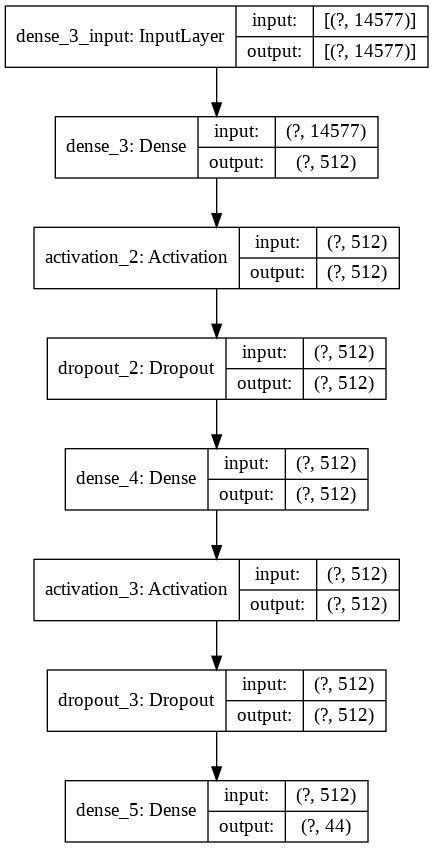

In [36]:
from keras.utils import plot_model
plot_model(clf.model, show_shapes=True)

In [26]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'

    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

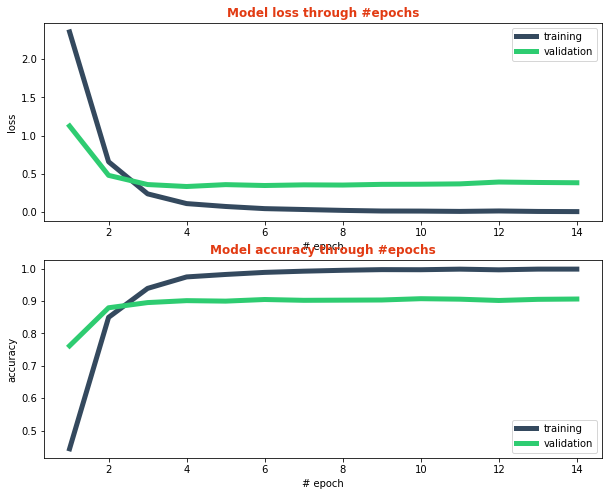

In [37]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('accuracy', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_accuracy', [])
)

In [38]:
score = clf.score(X_test_, y_test_)
print(score)

8/8 [==============================] - 0s 9ms/step - loss: 0.3795 - accuracy: 0.9115
0.9114999771118164


In [51]:
text

"It's 2AM, so I am about to going to my bed."

In [50]:
# text 에 대해 DL model로 POS tagging 한 결과 
clf.predict(dict_vectorizer.transform([add_basic_features(word_tokenize(text), index) for index in range(len(word_tokenize(text)))]))

1/1 [==============================] - 0s 2ms/step


array([25, 38, 20,  3, 13, 25, 37, 13, 32, 35, 32, 26, 34,  7])